# Calculate orbital fits

This notebook shows a minimal set of code to do an orbital fit to observed data using routines in `orbits.py`. See the code in that file for more details on individual routines. 

Example data comes from the paper [Orbital Motion of the Wide Planetary-mass Companion GSC 6214-210 b: No Evidence for Dynamical Scattering](https://iopscience.iop.org/article/10.3847/1538-3881/aafacb/meta) by L. Pearce et al. 


In [12]:
# Make division and print() behave like Python 3 even if 
# using Python 2.x:
from __future__ import print_function, division

# Import the key packages we need:
import numpy as np
import matplotlib.pyplot as plt
# Make default font a bit bigger:
import matplotlib
matplotlib.rcParams['font.size'] = 18   # Font size in points

from astropy.table import Table
import time as Time

import orbits

# Plots show in the notebook, not pop-up:
%matplotlib inline


In [13]:
overall_start_time = Time.time()

# Distance to the system in pc:
d_pc = 108.8  # cf. Dupuy et al.  
# Name of the system we're fitting: 
star_name = "GSC 6214-210 b"

# Read in orbital data, which we have saved in a file. 
# Positions are in milliarcsecond units.  Different conversions
# might be needed if your data are in different units.
datafile = "GSC 6214-210 b.txt"
t = Table.read(datafile, format='ascii.commented_header')

# Convert the position angle and separation to RA and Dec separation: 
ra_obs, dec_obs, ra_errs, dec_errs = orbits.rho_PA_to_RA_Dec( t['rho'],t['PA'], \
                                                              t['rho_err'], t['PA_err'])

# Careful with our x-y coordinate system - not the same as RA-Dec!
x_obs = dec_obs
y_obs = ra_obs
x_errs = dec_errs
y_errs = ra_errs

# Code below assumes dates in years.  Convert if necessary. 
times_obs = t['Date']

In [14]:
# Now that we have the data, find the best fit
# orbit by searching over a range of parameters:

# Get the start date of the data - we'll use
# this to set what times of periastron we test:
data_start = np.min(times_obs)

# Set trial orbital elements over a range.
# Careful specifying this number - the output grid is of size n**3
# This takes about 5 seconds with n = 100; time should scale 
# from there roughly as (5 seconds) * (n/100)**3
n = 100

# Call a routine to define a grid of search parameters. 
# Default is to search all eccentricities and periastrons.  Periods
# to search are passed as log(years), so 1 to 3 is periods of 10 to 
# 1000 years, for example.  For this system, we have a better constraint 
# on the period since we have most of the orbit. 

e_max = 0.99

logP_min = np.log10(750)
logP_max = np.log10(100000)
P_array, e_array, T_array = orbits.grid_P_e_T(n, logP_min, logP_max, T_start=data_start, e_max=e_max)

# This is just to see how long it takes:
start_time = Time.time()


# This is the routine that really does the optimization, returning parameters for 
# *all* the orbits it tries, and their chi-squares: 
A_array, B_array, F_array, G_array, sigma_list, chi_squared = orbits.Thiele_Innes_optimal(times_obs, P_array, e_array, \
                                                                              T_array, x_obs, y_obs, \
                                                                              x_errs, y_errs, debug=False)

# Now optimize the grid a bit - only keep values within the bounds that give 
# delta chi squared less than 10 from the best fit found so far: 

best_chi_squared = np.min(chi_squared)
delta_chi_squared = 10
good_inds = np.where((chi_squared - best_chi_squared) < delta_chi_squared)

e_min = np.min(e_array[good_inds])
e_max = np.max(e_array[good_inds])

logP_min = np.log10(np.min(P_array[good_inds]))
logP_max = np.log10(np.max(P_array[good_inds]))

tau_min = np.min((T_array[good_inds] - data_start)/P_array[good_inds])
tau_max = np.max((T_array[good_inds] - data_start)/P_array[good_inds])

print("First grid pass of %d points took %0.1f seconds." % (n**3, Time.time() - start_time))
print("Doing regridded search from logP = %0.1f to %0.1f, e = %0.2f to %0.2f, tau = %0.2f to %0.2f" % \
     (logP_min, logP_max, e_min, e_max, tau_min, tau_max))

# Now regrid with these bounds, and run grid search again: 
P_array, e_array, T_array = orbits.grid_P_e_T(n, logP_min, logP_max, e_min, e_max, \
                                              tau_min, tau_max, T_start=data_start)
A_array, B_array, F_array, G_array, sigma_list, chi_squared = orbits.Thiele_Innes_optimal(times_obs, P_array, e_array, \
                                                                              T_array, x_obs, y_obs, \
                                                                              x_errs, y_errs, debug=False)



# Then take these and get the other orbital parameters, too: 
w_array, a_array, i_array, Omega_array = orbits.Campbell_from_Thiele_Innes(A_array, B_array, F_array, G_array)

print("Double grid search of %d points took %0.1f seconds." % (n**3, Time.time() - start_time))


mass_array = (a_array*d_pc/1000.)**3 / P_array**2


# Here is an example of how one might implement a mass prior;
# for this orbit we won't do it since we have a lot of data;

# Modify the likelihood via a prior on total stellar mass - 
# decaying power law (from the IMF) above some mass value: 
#mass_cutoff = 1.0
#mass_prior = (mass_array/mass_cutoff)**(-2.3)
# That straight power law overweights the low mass end, about which we 
# want to be agnostic - so just set a flat prior below the cutoff: 
#low_mass = mass_array < mass_cutoff
#mass_prior[low_mass] = 1

# Measured masses from Dupuy et al: 
lit_mass = 0.84384
lit_mass_error = 0.021908
lit_d = d_pc
lit_d_error = 0.5

#mass_prior_func = orbits.mass_distance_prior(lit_mass, lit_mass_error, lit_d, lit_d_error)

#mass_prior = mass_prior_func((a_array/1000.)**3/P_array**2)

#i_prior = np.sin(i_array)

prior = orbits.prior(lit_mass, lit_mass_error, lit_d, lit_d_error, (a_array/1000.)**3/P_array**2, i_array, a_array)

# Calculate reduced chi-squared: 
reduced_chi_squared = chi_squared/(times_obs.size - 3)

# Likelihood of a given model is exp(-chi_squared/2); calculate and normalize
# also taking the prior into account:
likelihood = np.exp(-0.5*reduced_chi_squared) * prior
norm_likelihood = likelihood/np.sum(likelihood)


# Find the entry with highest likelihood.  This two-step syntax is only 
# necessary if the chi_squared array has more than one dimension, but 
# still works for 1D: 
z_flat = np.argmax(likelihood)
z = np.unravel_index(z_flat, likelihood.shape)

# Print best chi-squared value, ideally around 1 if it's a good fit: 
min_chi = reduced_chi_squared[z]
print("Reduced chi-squared of most likely fit is %0.2f." % reduced_chi_squared[z])

# And print the orbital parameters, converting some to degrees as needed: 
print("Best-fit:\n e: %0.2f \n P: %0.3f \n T: %0.1f \n w: %0.2f \n a: %0.1f \n i: %0.1f \n Omega: %0.1f \n Stellar mass: %0.3f" % \
      (e_array[z], P_array[z], T_array[z], np.rad2deg(w_array[z]), a_array[z], 
          np.rad2deg(i_array[z]), np.rad2deg(Omega_array[z]), mass_array[z]))

# Calculate the positions from the best-fit orbit:
P_best = P_array[z]
t_min = np.min(times_obs)
# This grid of times is just to have enough points to make a smooth orbit: 
t_grid = np.linspace(t_min - P_best*0.6, t_min + P_best*0.6, 400)
RA_mas_fit, Dec_mas_fit = orbits.keplerian_xy_Thiele_Innes(t_grid, \
                                                   A_array[z], B_array[z], F_array[z], G_array[z], \
                                                   T_array[z], e_array[z], P_array[z])



First grid pass of 1000000 points took 3.3 seconds.
Doing regridded search from logP = 2.9 to 5.0, e = 0.00 to 0.99, tau = 0.00 to 0.99
Double grid search of 1000000 points took 7.2 seconds.
0.036582797382923526
Reduced chi-squared of most likely fit is 1.96.
Best-fit:
 e: 0.68 
 P: 1918.129 
 T: 2852.4 
 w: 4.70 
 a: 1341.5 
 i: 118.6 
 Omega: 0.6 
 Stellar mass: 0.845


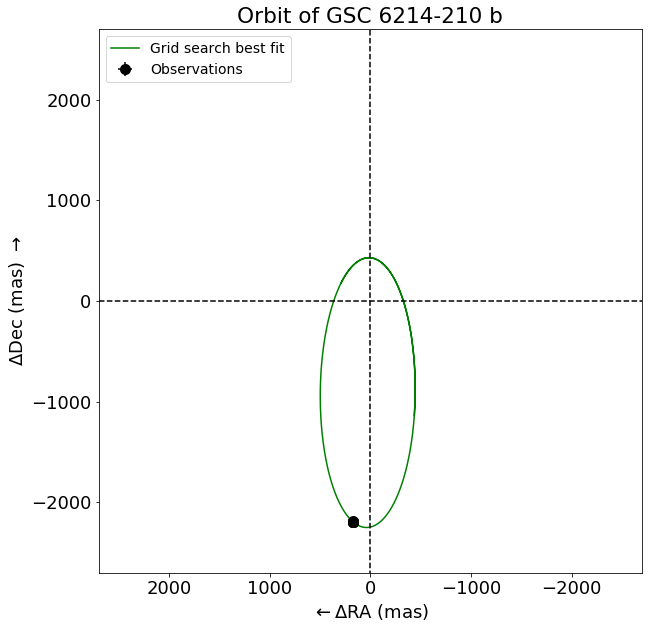

In [ ]:
# And now plot against the data, for comparison:

plt.figure(figsize=(10,10))  # Units are inches
# Make default font a bit bigger:
matplotlib.rcParams['font.size'] = 18   # Font size in points

plt.plot(RA_mas_fit, Dec_mas_fit, color='green', label="Grid search best fit")

# Also plot the observed data:
plt.errorbar(ra_obs, dec_obs, xerr=ra_errs, yerr=dec_errs, 
             fmt='ko', markersize=10, label="Observations")


# Set the limits to be useful for seeing the data - may need
# to change this:
boundary = 1.2*np.max([np.max(abs(RA_mas_fit)), np.max(abs(Dec_mas_fit))])

xmin = -1*boundary
xmax = boundary
ymin = -1*boundary
ymax = boundary
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Add dashed lines showing the zero points.
# Make the values bigger than the limits, so 
# they go all the way to the edge: 
plt.plot([0,0], [ymin*1.1,ymax*1.1], 'k----')
plt.plot( [xmin*1.1, xmax*1.1], [0,0], 'k----')

# RA is positive to the left, so flip the x axis:
ax = plt.gca()
ax.invert_xaxis()
# Make the plot square:
ax.set(aspect='equal')
plt.xlabel("$\leftarrow \Delta$RA (mas)")
plt.ylabel(r"$\Delta$Dec (mas) $\rightarrow $")
plt.title("Orbit of %s" % star_name)
plt.legend(loc="upper left", fontsize=14, numpoints=1)
#plt.savefig("%s_orbit_fit.png" % star_name)
plt.show()

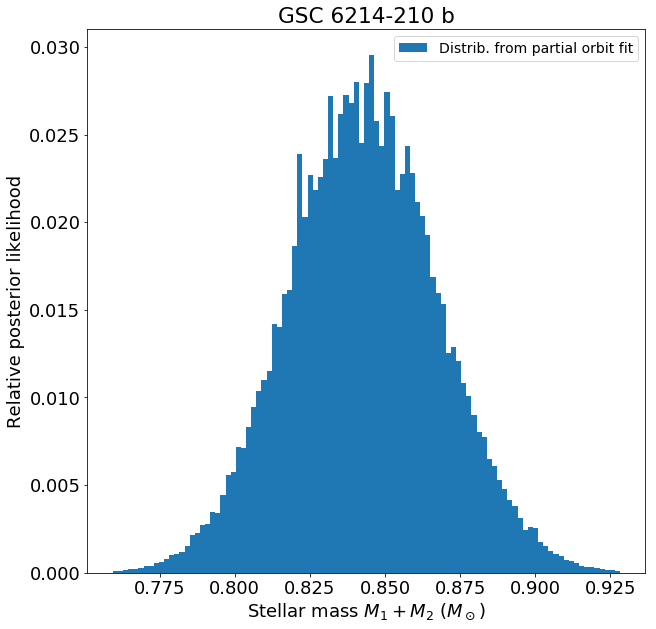

In [ ]:
# Now make a histogram of the masses, weighed by their likelihood: 

# Now plot posterior distributions of some parameters:
bins = np.linspace(lit_mass*0.9,lit_mass*1.1,100)
plt.figure(figsize=(10,10))  # Units are inches
plt.hist(mass_array, weights=norm_likelihood, bins=bins, \
        label="Distrib. from partial orbit fit") 
plt.xlabel("Stellar mass $M_1 + M_2$ ($M_\odot$)")
plt.ylabel("Relative posterior likelihood")
plt.title(star_name)
plt.legend(fontsize=14, numpoints=1)
# Uncomment to save a plot to a file: 
#plt.savefig("%s_stellar_mass_dist.png" % star_name)
plt.show()


In [ ]:
# Now get a more refined version of the mass posterior: 

# Resample the above grid by an extra factor of N, following 
# method in Lucy 2014B:

N = 50

start_time = Time.time()

w_N, a_N, i_N, T_N, e_N, P_N, Omega_N, new_likelihood, script_ABFG = orbits.correct_orbit_likelihood(\
                                                                                    P_array, e_array, \
                                                                                    T_array, A_array, \
                                                                                    B_array, F_array, \
                                                                                    G_array, sigma_list,\
                                                                                    chi_squared, N)

end_time = Time.time()
print("Regridding by factor of %d took %0.1f seconds." % (N, end_time - start_time))


# Now get the new posterior:
new_likelihood_norm = new_likelihood/np.sum(new_likelihood)

mass_N = (a_N*d_pc/1000.)**3 / P_N**2

#mass_prior = mass_prior_func((a_N/1000.)**3/P_N**2)

#i_prior = np.sin(i_N)

prior = orbits.prior(lit_mass, lit_mass_error, lit_d, lit_d_error, (a_N/1000.)**3/P_N**2, i_N, a_N)

# Now modify the likelihood with the prior:
new_likelihood = new_likelihood * prior
new_likelihood_norm = new_likelihood/np.sum(new_likelihood)


log_mass_N = np.log10(mass_N)
weighted_mean_mass = 10**(np.sum(log_mass_N * new_likelihood_norm))
print("New (resampled) weighted mean mass is %0.4f Msun." % weighted_mean_mass)

old_weighted_mean_mass = 10**(np.sum(np.log10(mass_array) * norm_likelihood))
print("Old (naive) weighted mean mass is %0.4f Msun." % old_weighted_mean_mass)



Regridding by factor of 50 took 16.0 seconds.
0.02593506310062635
New (resampled) weighted mean mass is 0.8426 Msun.
Old (naive) weighted mean mass is 0.8426 Msun.


In [ ]:
# Get the credible interval for the mass determination:

logm_mean, logm_low, logm_high = orbits.credible_interval(log_mass_N, new_likelihood)
mass_low = 10**logm_low
mass_high = 10**logm_high
mass_mean = 10**logm_mean
print("68%% credible interval: %0.3f to %0.3f Msun, mean of %0.3f Msun." % (mass_low, mass_high, mass_mean))

low_mass_err = mass_mean - mass_low
high_mass_err = mass_high - mass_mean

In [ ]:
#Radians to degrees
i_N = np.rad2deg(i_N)
w_N = np.rad2deg(w_N)
Omega_N = np.rad2deg(Omega_N)

#milliarcseconds to AU
a_N = orbits.mas2AU(a_N, d_pc)

#Creating periastron array
Peri_N = a_N*(1-e_N)

# Get the credible interval for the semimajor axis: 
P_mean, P_low, P_high = orbits.credible_interval(P_N, new_likelihood) 
e_mean, e_low, e_high = orbits.credible_interval(e_N, new_likelihood) 
T_mean, T_low, T_high = orbits.credible_interval(T_N, new_likelihood) 
a_mean, a_low, a_high = orbits.credible_interval(a_N, new_likelihood)
i_mean, i_low, i_high = orbits.credible_interval(i_N, new_likelihood) 
w_mean, w_low, w_high = orbits.credible_interval(w_N, new_likelihood) 
Omega_mean, Omega_low, Omega_high = orbits.credible_interval(Omega_N, new_likelihood)
Peri_mean, Peri_low, Peri_high = orbits.credible_interval(Peri_N, new_likelihood)

print("68%% P credible interval: %0.3f to %0.3f, mean of %0.3f." % (P_low, P_high, P_mean))
print("68%% e credible interval: %0.3f to %0.3f, mean of %0.3f." % (e_low, e_high, e_mean))
print("68%% T credible interval: %0.3f to %0.3f, mean of %0.3f." % (T_low, T_high, T_mean))
print("68%% a credible interval: %0.3f to %0.3f, mean of %0.3f." % (a_low, a_high, a_mean))
print("68%% i credible interval: %0.3f to %0.3f, mean of %0.3f." % (i_low, i_high, i_mean))
print("68%% w credible interval: %0.3f to %0.3f, mean of %0.3f." % (w_low, w_high, w_mean))
print("68%% Omega credible interval: %0.3f to %0.3f, mean of %0.3f." % (Omega_low, Omega_high, Omega_mean))
print("68%% Periastron credible interval: %0.3f to %0.3f, mean of %0.3f." % (Peri_low, Peri_high, Peri_mean))

P_err_low = P_mean - P_low
P_err_high = P_high - P_mean

e_err_low = e_mean - e_low
e_err_high = e_high - e_mean

T_err_low = T_mean - T_low
T_err_high = T_high - T_mean

a_err_low = a_mean - a_low
a_err_high = a_high - a_mean

i_err_low = i_mean - i_low
i_err_high = i_high - i_mean

w_err_low = w_mean - w_low
w_err_high = w_high - w_mean

Omega_err_low = Omega_mean - Omega_low
Omega_err_high = Omega_high - Omega_mean

Peri_err_low = Peri_mean - Peri_low
Peri_err_high = Peri_high - Peri_mean

In [ ]:
print("Full calculation took %0.1f seconds." % (end_time - overall_start_time))

In [ ]:
mass_info = orbits.store_parameter_info('Mass', mass_N, mass_mean, mass_low, mass_high, lit_param=lit_mass, \
                                       lit_param_err_low=low_mass_err, lit_param_err_high=high_mass_err)

P_info = orbits.store_parameter_info('P', P_N, P_mean, P_low, P_high)

T_info = orbits.store_parameter_info('T', T_N, T_mean, T_low, T_high)

e_range = [0.0, 1.0]
e_info = orbits.store_parameter_info('e', e_N, e_mean, e_low, e_high, graph_range=e_range)

a_range = [100, 500]
a_info = orbits.store_parameter_info('a', a_N, a_mean, a_low, a_high, graph_range=a_range)

i_range = [80, 180]
i_info = orbits.store_parameter_info('i', i_N, i_mean, i_low, i_high, graph_range=i_range)

w_range = [0, 360]
w_info = orbits.store_parameter_info('w', w_N, w_mean, w_low, w_high, graph_range=w_range)

Omega_range = [0, 180]
Omega_info = orbits.store_parameter_info('Omega', Omega_N, Omega_mean, Omega_low, Omega_high, graph_range=Omega_range)

parameter_info = [mass_info, P_info, T_info, e_info, a_info, i_info, w_info, Omega_info]
orbits.loop_posteriors(new_likelihood_norm, star_name, parameter_info)